In [1]:
import re
import nltk
import sklearn
import matplotlib
import numpy             as np
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt

from pprint              import pprint
from bokeh.io            import output_notebook, show
from bokeh.models        import ColumnDataSource
from bokeh.palettes      import Spectral6
from bokeh.plotting      import figure
from lib.data_preprocess import Preprocess
from nltk.corpus         import stopwords 
from nltk.tokenize       import word_tokenize
from PIL                 import Image
from wordcloud           import WordCloud, STOPWORDS, ImageColorGenerator


output_notebook()
sns.set_style('whitegrid')
nltk.download('stopwords')
nltk.download('punkt')

font = {'size'   : 15}
matplotlib.rc('font', **font)

Loading BokehJS ...

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yihsiang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yihsiang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data preprocessing

In [2]:
train_path = 'dataset/labeledTrainData.tsv'
test_path  = 'dataset/testData.tsv'

# read in the dataset
pp                = Preprocess()
train_df, test_df = pp.read_file(train_path, test_path, sep='\t')

# check for missing value
print('Training set:')
pp.check_na(train_df)
print()

print('Test set:')
pp.check_na(test_df)

Training set:
============== Data Info ==============
Number of rows: 25000
Number of cols: 3
========== Missing Data Info ==========
     Columns  Count DataType
0         id      0   object
1  sentiment      0    int64
2     review      0   object

Test set:
============== Data Info ==============
Number of rows: 25000
Number of cols: 2
========== Missing Data Info ==========
  Columns  Count DataType
0      id      0   object
1  review      0   object


In [3]:
display(train_df[['id', 'review', 'sentiment']].head(10))

,id,review,sentiment
0,5814_8,With all this stuff going down at the moment w...,1
1,2381_9,"\The Classic War of the Worlds\"" by Timothy Hi...",1
2,7759_3,The film starts with a manager (Nicholas Bell)...,0
3,3630_4,It must be assumed that those who praised this...,0
4,9495_8,Superbly trashy and wondrously unpretentious 8...,1
5,8196_8,I dont know why people think this is such a ba...,1
6,7166_2,"This movie could have been very good, but come...",0
7,10633_1,I watched this video at a friend's house. I'm ...,0
8,319_1,"A friend of mine bought this film for £1, and ...",0
9,8713_10,<br /><br />This movie is full of references. ...,1


In [4]:
stop_words = set(stopwords.words('english'))

In [5]:
# convert it to lower space
train_df.review = train_df.review.str.lower()

# pattern
sym_removal = lambda review: re.sub(r'(\.{2,})|(\\{1,})|[\(\),¨\":-]' , ' ', review)
dup_removal = lambda string: re.sub(r'(.)\1+', r'\1\1', string)
tag_removal = lambda review: re.sub(r'<[^>]*>'    , '' , review)
spc_removal = lambda review: re.sub(r'[\s]+'      , ' ', review)
chr_removal = lambda review: re.sub(r'\'[a-z]*\s' , ' ' , review)


# replace words or substrings which match the pattern
train_df.review = train_df.review.apply(tag_removal)
train_df.review = train_df.review.apply(chr_removal)
train_df.review = train_df.review.apply(sym_removal)
train_df.review = train_df.review.apply(spc_removal)
train_df.review = train_df.review.apply(dup_removal)

# plotting wordcloud
stop_words   = set(stopwords.words('english'))
bad_review   = train_df.loc[train_df['sentiment'] == 0, 'review'].values.copy()
good_review  = train_df.loc[train_df['sentiment'] == 1, 'review'].values.copy()
# bad_review   = " ".join(r for r in train_df.loc[train_df['sentiment'] == 0, 'review'].values.copy())
# good_review  = " ".join(r for r in train_df.loc[train_df['sentiment'] == 1, 'review'].values.copy())



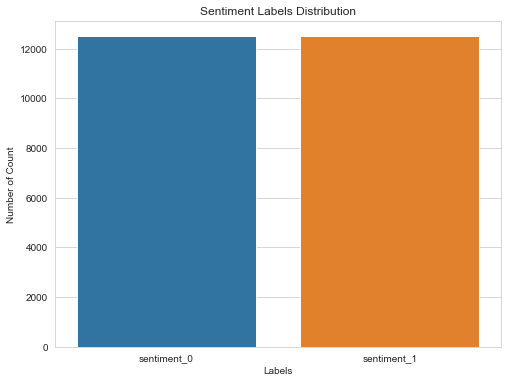

Average word count in a sentence: 1270


In [6]:
labels, counts = np.unique(train_df.sentiment.values, return_counts=True)
labels         = ['sentiment_' + str(label) for label in labels]

plt.figure(figsize=(8,6))
plt.title('Sentiment Labels Distribution')
plt.xlabel('Labels')
plt.ylabel('Number of Count')
sns.barplot(x=labels, y=counts)
plt.show()

avg_words = [len(sentence) for sentence in train_df.review.values]
avg_words = int(np.sum(avg_words) / train_df.shape[0])
print('Average word count in a sentence:', avg_words)


In [7]:
def get_high_frequent_word(feature_name, reviews, max_length=200):
    word_count = {w: 0 for w in feature_name}

    for sentence in reviews:
        for w in sentence.split():
            if w in word_count.keys():
                word_count[w] += 1
                
    high_frequent_words = np.array(sorted(word_count.items(), key = lambda kv:(kv[1], kv[0])))    
                
    return high_frequent_words[-max_length:,0]



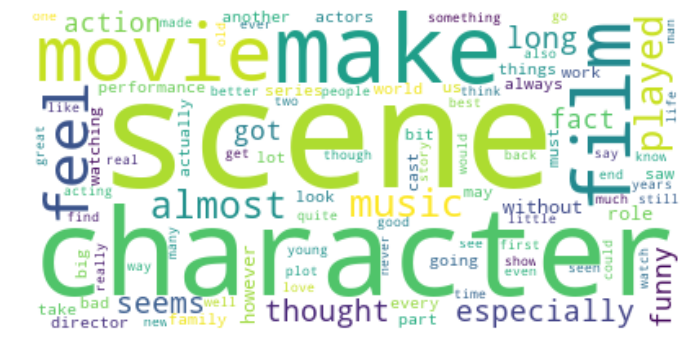

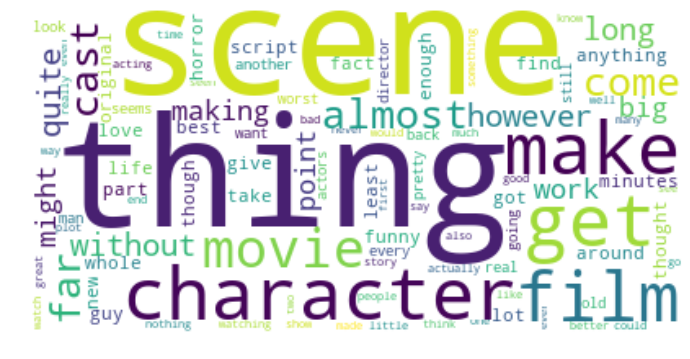

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer   = TfidfVectorizer(sublinear_tf=True, analyzer='word', max_features=500)
bad_vct      = vectorizer.fit_transform(bad_review)
hf_words     = get_high_frequent_word(vectorizer.get_feature_names(), bad_review)
bad_review   = " ".join(w for w in hf_words)
bad_wdcloud  = WordCloud(stopwords=stop_words, background_color="white").generate(bad_review)

vectorizer   = TfidfVectorizer(sublinear_tf=True, analyzer='word',max_features=500)
good_vct     = vectorizer.fit_transform(good_review)
hf_words     = get_high_frequent_word(vectorizer.get_feature_names(), good_review)
good_review  = " ".join(w for w in hf_words)
good_wdcloud = WordCloud(stopwords=stop_words, background_color="white").generate(good_review)

plt.figure(figsize=(16,6))
plt.imshow(good_wdcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

plt.figure(figsize=(16,6))
plt.imshow(bad_wdcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# tokenize and remove stop words
stop_words_removal = lambda string: [w for w in word_tokenize(string) if w not in stop_words]
train_df.review    = train_df.review.apply(stop_words_removal)